segment를 분류하는 알고리즘 -> segment를 나눠서 따로 모델을 적용

322, 222, 122 외에 다른 segment가 들어올 때 어떻게 처리?

신규고객 누적 가입 -> 허상지표

# XGBoost 모델

Boost모델 중 Gradient Boosting의 일종으로 회귀, 분류 문제에 모두 사용 가능 <br>
Boost모델 : 이전 모델의 오류를 고려하여 다음 모델이 순차적으로 학습됨 (vs Bagging - random forest) <br>
Boost모델 장점 : Bias 감소, 과소적합 해결 <br>
Gradient Boosting : 틀린 데이터에 집중하기 위해, 가중 샘플링을 하는 대신 잔차 학습




### 특성 정리 <br>

gender : 성별 <br>
home_location : 지역위치 <br>
first_join_date : 처음 가입 날짜 <br>
age_segment : 나이 그룹 <br>
RFM_Segment : RFM 그룹 <br>
low : 하위 10% 로 구매한 비율 <br>
high : 상위 10% 로 구매한 비율 <br>
book_cnt : 구매 횟수 <br>
time / event : 이벤트 평균 길이(s) <br>
add_book_mean : add_to_cart 에서 booking 사이에 평균 시간 (days) <br>
revisit : 평균 재방문 주기 <br> 
session_cnt : 방문횟수(session 수) <br> 
add_last_event_ratio : add_to_cart 로 끝나는 세션의 비율 <br> 
promo_use_ratio : 프로모션 적용한 구매 비율 <br> 
average_revenue : 세션당 객단가 <br> 
churn : 이탈 여부 (target)

In [965]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from category_encoders import OrdinalEncoder
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import timedelta
from imblearn.over_sampling import SMOTE
pd.options.display.float_format = '{:.2f}'.format


In [966]:
base_path = os.getcwd()
df = pd.read_csv(base_path + '/feature_target(5-7).csv')
df.rename(columns={'bounce':'churn'}, inplace=True)
df = df.iloc[:,1:]
df.head()

,gender,home_location,first_join_date,age_segment,RFM_Segment,low,high,book_cnt,time/event,add_book_mean,revisit,session_cnt,add_last_event_ratio,promo_use_ratio,average_revenue,churn
0,M,Nusa Tenggara Barat,2020-08-23,Early 30s(31-35),322.00,0.14,0.07,4.00,239.71,0.21,0 days 15:58:49.500000,37.00,0.00,0.25,169228.25,1
1,M,Kalimantan Selatan,2021-04-11,Early 20s(21-25),111.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,1
2,F,Bengkulu,2022-01-09,minor(15-20),211.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,1
3,F,Jawa Barat,2019-09-12,Late 20s(26-30),111.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,1
4,F,Yogyakarta,2019-11-21,Late 20s(26-30),111.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,1


In [967]:
df = df.drop_duplicates()

데이터 전처리

In [968]:
df.book_cnt.describe()

count   95587.00
mean        0.88
std         1.73
min         0.00
25%         0.00
50%         0.00
75%         1.00
max        75.00
Name: book_cnt, dtype: float64

In [969]:
df.book_cnt.quantile(0.8)

1.0

In [970]:
df.describe()

,RFM_Segment,low,high,book_cnt,time/event,add_book_mean,session_cnt,add_last_event_ratio,promo_use_ratio,average_revenue,churn
count,95587.00,95587.00,95587.00,95587.00,95587.00,95587.00,95587.00,95587.00,95587.00,95587.00,95587.00
mean,248.05,0.05,0.05,0.88,78.81,1.32,9.22,0.06,0.13,254206.38,0.72
std,82.61,0.08,0.08,1.73,151.97,2.82,18.04,0.12,0.29,551941.74,0.45
min,111.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,211.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,311.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,322.00,0.11,0.11,1.00,100.76,1.38,11.00,0.05,0.00,308947.50,1.00
max,322.00,1.00,1.00,75.00,1619.56,29.39,388.00,1.00,1.00,15260856.00,1.00


In [971]:
df = df.drop(['add_last_event_ratio', 'promo_use_ratio'], axis = 1)
df = df[(df['book_cnt'] < 1) | (df['low'] <= 0.11) | (df['high'] <= 0.11) | (df['session_cnt'] <= 11)]


In [972]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89591 entries, 0 to 152096
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           89591 non-null  object 
 1   home_location    89591 non-null  object 
 2   first_join_date  89591 non-null  object 
 3   age_segment      89591 non-null  object 
 4   RFM_Segment      89591 non-null  float64
 5   low              89591 non-null  float64
 6   high             89591 non-null  float64
 7   book_cnt         89591 non-null  float64
 8   time/event       89591 non-null  float64
 9   add_book_mean    89591 non-null  float64
 10  revisit          89591 non-null  object 
 11  session_cnt      89591 non-null  float64
 12  average_revenue  89591 non-null  float64
 13  churn            89591 non-null  int64  
dtypes: float64(8), int64(1), object(5)
memory usage: 10.3+ MB


In [973]:
# 시계열 데이터 제거
df.drop('first_join_date', axis=1, inplace=True)

In [974]:
# revisit(재방문 주기) : 초로 나타내서 int로 표현
df['revisit'] = pd.to_timedelta(df['revisit']).dt.total_seconds()
df['revisit']

0         57529.50
1             0.00
2             0.00
3             0.00
4             0.00
            ...   
152084        0.00
152086   690609.00
152094        0.00
152095    84355.00
152096        0.00
Name: revisit, Length: 89591, dtype: float64

In [975]:
df['RFM_Segment'] = df['RFM_Segment'].astype('int').astype('str')

In [976]:
# 타겟 불균형 확인
df.churn.value_counts(normalize=True)

1   0.72
0   0.28
Name: churn, dtype: float64

In [977]:
# R, F, M 분리
df['Recency'] = df['RFM_Segment'].str[0]
df['Frequency'] = df['RFM_Segment'].str[1]
df['Monetary'] = df['RFM_Segment'].str[-1]

df.drop('RFM_Segment', axis=1, inplace=True)

## 모델 1. 모든 특성 사용

In [978]:
# 타겟 설정
target = 'churn'

# SMOTE 적용
smote = SMOTE()

# 특성과 목표 변수 분리
X = df.drop(columns=['churn'], axis=1)
y = df['churn']

# 학습/테스트 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

X_train_oe = OrdinalEncoder().fit_transform(X_train)


# SMOTE 적용
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train_oe, y_train)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=2)

X_val = OrdinalEncoder().fit_transform(X_val)
X_test = OrdinalEncoder().fit_transform(X_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(103900, 14)
(14335, 14)
(3584, 14)


In [979]:
pipe = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc", 
        n_estimators=50,
        random_state=2,
        n_jobs=-1,
        max_depth=5,
        learning_rate=0.1,
        min_child_weight=16,
        subsample=0.8,
        )
    )

print(pipe)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=16, missing=nan,
                               monotone_constraints=None, n_estimator

In [980]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=16, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=2, ...))])

In [981]:
# train 학습, 검증셋 정확도
print("학습 정확도", pipe.score(X_train, y_train))
print("검증 정확도", pipe.score(X_val, y_val))
y_pred = pipe.predict(X_val)
print("ROC_AUC_score", roc_auc_score(y_val, y_pred))
print('f1-score', f1_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

학습 정확도 0.6300577478344562
검증 정확도 0.5496337635158702
ROC_AUC_score 0.5314862670083372
f1-score 0.6464403066812705
              precision    recall  f1-score   support

           0       0.31      0.49      0.38      4035
           1       0.74      0.57      0.65     10300

    accuracy                           0.55     14335
   macro avg       0.53      0.53      0.51     14335
weighted avg       0.62      0.55      0.57     14335



<Axes: >

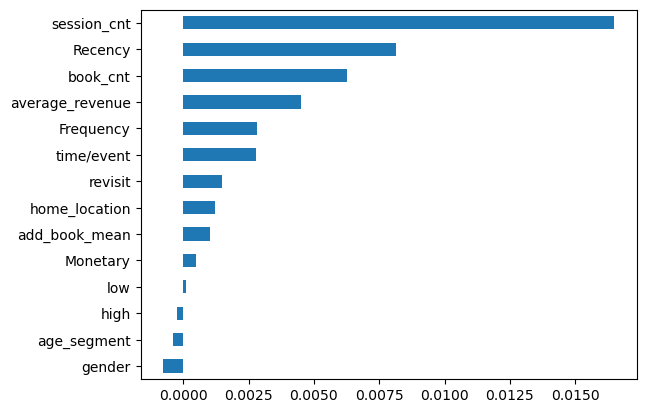

In [982]:
# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps["xgbclassifier"],  # model
    scoring="roc_auc",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=2,
)

# 스코어를 다시 계산합니다.
X_val_preprocessed = pipe[0].transform(X_val)
permuter.fit(X_val_preprocessed, y_val)

feature_names = X_val_preprocessed.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()

In [983]:
# 특성별 score을 확인합니다.
eli5.show_weights(
    permuter,
    top=None,  # top n 지정 가능, None 일 경우 모든 특성
    feature_names=feature_names,  # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0165 ± 0.0079,session_cnt
0.0081 ± 0.0051,Recency
0.0063 ± 0.0053,book_cnt
0.0045 ± 0.0048,average_revenue
0.0028 ± 0.0030,Frequency
0.0028 ± 0.0031,time/event
0.0015 ± 0.0022,revisit
0.0012 ± 0.0030,home_location
0.0010 ± 0.0013,add_book_mean
0.0005 ± 0.0015,Monetary


## 모델 2. gender 제외 (성능 차이가 없어 그냥 모든 특성 사용)

In [984]:
df2 = df.copy()
df2.drop(['gender','high', 'age_segment', 'add_book_mean', 'low'], axis=1, inplace=True)
df2.head()

,home_location,book_cnt,time/event,revisit,session_cnt,average_revenue,churn,Recency,Frequency,Monetary
0,Nusa Tenggara Barat,4.00,239.71,57529.50,37.00,169228.25,1,3,2,2
1,Kalimantan Selatan,0.00,0.00,0.00,0.00,0.00,1,1,1,1
2,Bengkulu,0.00,0.00,0.00,0.00,0.00,1,2,1,1
3,Jawa Barat,0.00,0.00,0.00,0.00,0.00,1,1,1,1
4,Yogyakarta,0.00,0.00,0.00,0.00,0.00,1,1,1,1


In [985]:
# 타겟 설정
target = 'churn'

# 학습/테스트 데이터 분리
X_train2 = X_train.drop(['session_cnt', 'age_segment'], axis=1)
X_val2 = X_val.drop(['session_cnt', 'age_segment'], axis=1)
X_test2 = X_test.drop(['session_cnt', 'age_segment'], axis=1)

In [986]:
pipe2 = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc", 
        n_estimators=50,
        random_state=2,
        n_jobs=-1,
        max_depth=10,
        learning_rate=0.1,
        min_child_weight=32,
        subsample=0.8
    )
)

pipe2.fit(X_train2, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=32, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=2, ...))])

In [987]:
# train 학습, 검증셋 정확도
print("학습 정확도", pipe2.score(X_train2, y_train))
print("검증 정확도", pipe2.score(X_val2, y_val))
y_pred2 = pipe2.predict(X_val2)
print("ROC_AUC_score", roc_auc_score(y_val, y_pred2))
print("f1-score", f1_score(y_val, y_pred2))
print(classification_report(y_val, y_pred2))

학습 정확도 0.6420404234841194
검증 정확도 0.5590512731077781
ROC_AUC_score 0.5285427870213304
f1-score 0.6610178581004988
              precision    recall  f1-score   support

           0       0.31      0.46      0.37      4035
           1       0.74      0.60      0.66     10300

    accuracy                           0.56     14335
   macro avg       0.52      0.53      0.52     14335
weighted avg       0.62      0.56      0.58     14335



## 하이퍼 파라미터 튜닝

In [988]:
X_train = X_train.drop(['session_cnt', 'age_segment'], axis=1)
X_val = X_val.drop(['session_cnt', 'age_segment'], axis=1)
X_test = X_test.drop(['session_cnt', 'age_segment'], axis=1)

### Randomized Search

In [989]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import uniform
from sklearn.metrics import make_scorer, recall_score

In [990]:
model = XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc", 
            n_estimators=50,
            random_state=2,
            n_jobs=-1,
            max_depth=10,
            learning_rate=0.1,
            min_child_weight=32,
            subsample=0.8,
        )


In [991]:
params = {
    "max_depth": list(range(5, 16)),
    "min_child_weight": [2, 4, 8],
    "colsample_bytree": uniform(
        loc=0.5, scale=0.5
    ),  
    "n_estimators" : [25, 50, 75, 100],
    "learning_rate" : [0.05,0.1,0.15,0.2],
    "subsample" : [0.6, 0.7, 0.8, 0.9],
}


randomized_search = RandomizedSearchCV(
    model,
    param_distributions=params,
    scoring="recall",
    n_iter=10,
    cv=5,
    verbose=3,
    random_state=2,
)

randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV 1/5] END colsample_bytree=0.7179974510710019, learning_rate=0.1, max_depth=13, min_child_weight=8, n_estimators=100, subsample=0.8;, score=0.575 total time=   4.2s


KeyboardInterrupt: 

In [ ]:
print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 Recall: ", randomized_search.best_score_)

최적 하이퍼파라미터:  {'colsample_bytree': 0.6439344079350022, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 25, 'subsample': 0.8}
최적 Recall:  0.8024905092321708


In [ ]:
best_params = {key.replace('xgbclassifier__', ''): value for key, value in randomized_search.best_params_.items()}

model_random_best = XGBClassifier(
                        objective="binary:logistic",
                        eval_metric="auc", 
                        random_state=2,
                        n_jobs=-1,
                        **best_params,
                        
                    )

model_random_best.fit(X_train, y_train, 
                      eval_set=[(X_val, y_val)], early_stopping_rounds=50)

[0]	validation_0-auc:0.49568
[1]	validation_0-auc:0.49409


/Users/hj/anaconda3/envs/t2project/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.49292
[3]	validation_0-auc:0.49553
[4]	validation_0-auc:0.49520
[5]	validation_0-auc:0.49321
[6]	validation_0-auc:0.49341
[7]	validation_0-auc:0.49368
[8]	validation_0-auc:0.49493
[9]	validation_0-auc:0.49419
[10]	validation_0-auc:0.49390
[11]	validation_0-auc:0.49272
[12]	validation_0-auc:0.49284
[13]	validation_0-auc:0.49278
[14]	validation_0-auc:0.49309
[15]	validation_0-auc:0.49245
[16]	validation_0-auc:0.49260
[17]	validation_0-auc:0.49256
[18]	validation_0-auc:0.49240
[19]	validation_0-auc:0.49230
[20]	validation_0-auc:0.49187
[21]	validation_0-auc:0.49159
[22]	validation_0-auc:0.49151
[23]	validation_0-auc:0.49221
[24]	validation_0-auc:0.49177


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6439344079350022, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=25, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2, ...)

In [ ]:
# train 학습, 검증셋 정확도
print("학습 정확도", model_random_best.score(X_train, y_train))
print("검증 정확도", model_random_best.score(X_val, y_val))
y_pred = model_random_best.predict(X_val)
print("ROC_AUC_score", roc_auc_score(y_val, y_pred))
print('f1-score', f1_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

학습 정확도 0.5702108276939094
검증 정확도 0.6143984220907298
ROC_AUC_score 0.5013259197143634
f1-score 0.738999833120098
              precision    recall  f1-score   support

           0       0.25      0.28      0.26      5960
           1       0.76      0.72      0.74     18376

    accuracy                           0.61     24336
   macro avg       0.50      0.50      0.50     24336
weighted avg       0.63      0.61      0.62     24336



In [ ]:
print("검증 정확도", model_random_best.score(X_test, y_test))
y_pred = model_random_best.predict(X_test)
print("ROC_AUC_score", roc_auc_score(y_test, y_pred))
print('f1-score', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

검증 정확도 0.5780736357659435
ROC_AUC_score 0.4947203706044304
f1-score 0.7032026823910279
              precision    recall  f1-score   support

           0       0.22      0.34      0.27      1398
           1       0.77      0.65      0.70      4686

    accuracy                           0.58      6084
   macro avg       0.50      0.49      0.49      6084
weighted avg       0.64      0.58      0.60      6084



### Baysian Search

In [ ]:
from hyperopt import hp
from hyperopt import fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

In [ ]:
params = {
    "xgbclassifier__max_depth": hp.quniform("max_depth", 2, 10, 2),
    "xgbclassifier__min_child_weight": hp.quniform("min_child_weight", 2, 10, 2),
    "xgbclassifier__colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
    "xgbclassifier__n_estimators" : hp.quniform("n_estimators", 25, 200, 25),
    "xgbclassifier__learning_rate" : hp.uniform("learning_rate", 0.05, 0.15),
    "xgbclassifier__subsample" : hp.uniform("subsample", 0.5, 1.0),
}

def get_pipe(params):
    
    for param in ["xgbclassifier__max_depth", "xgbclassifier__min_child_weight", "xgbclassifier__n_estimators"]:
        params[param] = int(
        params[param]
    )  
    
    pipe = make_pipeline(
        OrdinalEncoder(),
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc", 
            n_estimators=50,
            random_state=2,
            n_jobs=-1,
            max_depth=10,
            learning_rate=0.1,
            min_child_weight=32,
            subsample=0.8,
            
        )
        )
    
    pipe = pipe.set_params(**params)
    return pipe


def fit_and_eval(params):
    pipe = get_pipe(params)  # 주어진 params로 파이프라인을 만들어 가져옵니다.
    score = cross_val_score(pipe, X_train, y_train, cv=3, scoring="recall")
    avg_cv_score = np.mean(score)
    # roc_auc는 클수록 좋은 metric이므로, hyperopt.fmin이 roc_auc를 최대화하도록 하기 위해 -부호를 붙여 반환합니다.
    return {"loss": -avg_cv_score, "status": STATUS_OK}


trials = (
    Trials()
)  # Trials() 객체를 fmin에 함께 넣어 실행하면, 실행되는 매 fit의 학습 정보 및 학습 결과가 해당 객체에 모두 저장됩니다.

best_params = fmin(
    fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals=10,
    rstate = np.random.default_rng(2023)
)  # max_evals 횟수만큼 하이퍼파라미터 조합을 탐색합니다.

100%|██████████| 10/10 [01:40<00:00, 10.04s/trial, best loss: -0.8018935450286309]


In [ ]:
print("최적 하이퍼파라미터: ", trials.best_trial["misc"]["vals"])
print("최적 recall: ", -trials.best_trial["result"]["loss"])

최적 하이퍼파라미터:  {'colsample_bytree': [0.5630696944410877], 'learning_rate': [0.09926613924796096], 'max_depth': [4.0], 'min_child_weight': [6.0], 'n_estimators': [75.0], 'subsample': [0.5472176046185084]}
최적 recall:  0.8018935450286309


In [ ]:
model = XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc", 
            n_estimators=50,
            random_state=2,
            n_jobs=-1,
            max_depth=10,
            learning_rate=0.1,
            min_child_weight=32,
            subsample=0.8
            
        )


In [ ]:
best_params_baysian = {key.replace('xgbclassifier__', ''): value[0] for key, value in trials.best_trial["misc"]["vals"].items()}
for param in ["max_depth", "min_child_weight", "n_estimators"]:
    best_params_baysian[param] = int(
    best_params_baysian[param])

model_baysian_best = XGBClassifier(
                        objective="binary:logistic",
                        eval_metric="auc", 
                        random_state=2,
                        n_jobs=-1,
                        **best_params_baysian,
                        
                    )

model_baysian_best.fit(X_train, y_train, 
                      eval_set=[(X_val, y_val)], early_stopping_rounds=50)

[0]	validation_0-auc:0.49441


[1]	validation_0-auc:0.49458
[2]	validation_0-auc:0.49349
[3]	validation_0-auc:0.49364


/Users/hj/anaconda3/envs/t2project/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-auc:0.49272
[5]	validation_0-auc:0.49498
[6]	validation_0-auc:0.49513
[7]	validation_0-auc:0.49565
[8]	validation_0-auc:0.49750
[9]	validation_0-auc:0.49676
[10]	validation_0-auc:0.49588
[11]	validation_0-auc:0.49672
[12]	validation_0-auc:0.49708
[13]	validation_0-auc:0.49709
[14]	validation_0-auc:0.49631
[15]	validation_0-auc:0.49604
[16]	validation_0-auc:0.49719
[17]	validation_0-auc:0.49502
[18]	validation_0-auc:0.49468
[19]	validation_0-auc:0.49470
[20]	validation_0-auc:0.49440
[21]	validation_0-auc:0.49416
[22]	validation_0-auc:0.49443
[23]	validation_0-auc:0.49527
[24]	validation_0-auc:0.49528
[25]	validation_0-auc:0.49552
[26]	validation_0-auc:0.49549
[27]	validation_0-auc:0.49491
[28]	validation_0-auc:0.49522
[29]	validation_0-auc:0.49536
[30]	validation_0-auc:0.49531
[31]	validation_0-auc:0.49539
[32]	validation_0-auc:0.49492
[33]	validation_0-auc:0.49456
[34]	validation_0-auc:0.49415
[35]	validation_0-auc:0.49420
[36]	validation_0-auc:0.49423
[37]	validation_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5630696944410877, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09926613924796096,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=75, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2, ...)

In [ ]:
# train 학습, 검증셋 정확도
print("학습 정확도", model_baysian_best.score(X_train, y_train))
print("검증 정확도", model_baysian_best.score(X_val, y_val))
y_pred = model_baysian_best.predict(X_val)
print("ROC_AUC_score", roc_auc_score(y_val, y_pred))
print('f1-score', f1_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

학습 정확도 0.5740499739718896
검증 정확도 0.741370808678501
ROC_AUC_score 0.5017952362725819
f1-score 0.8501214459208459
              precision    recall  f1-score   support

           0       0.27      0.03      0.06      5960
           1       0.76      0.97      0.85     18376

    accuracy                           0.74     24336
   macro avg       0.51      0.50      0.45     24336
weighted avg       0.64      0.74      0.66     24336



In [ ]:
print("검증 정확도", model_baysian_best.score(X_test, y_test))
y_pred = model_baysian_best.predict(X_test)
print("ROC_AUC_score", roc_auc_score(y_test, y_pred))
print('f1-score', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

검증 정확도 0.6860618014464168
ROC_AUC_score 0.4930502510445689
f1-score 0.8066410204494837
              precision    recall  f1-score   support

           0       0.21      0.14      0.17      1398
           1       0.77      0.85      0.81      4686

    accuracy                           0.69      6084
   macro avg       0.49      0.49      0.49      6084
weighted avg       0.64      0.69      0.66      6084



<Axes: >

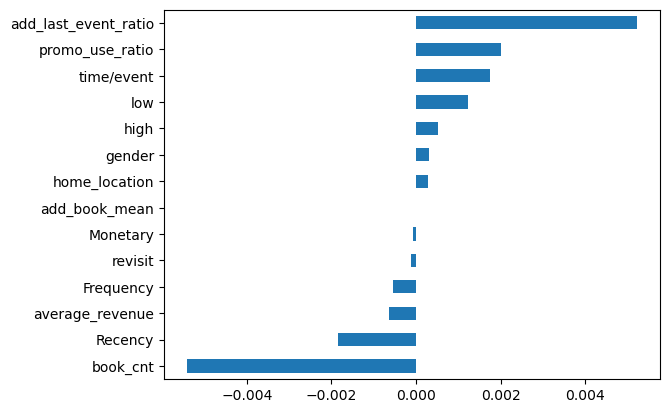

In [ ]:
# permuter 정의
permuter = PermutationImportance(
    model_baysian_best,  # model
    scoring="roc_auc",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=2,
)

# 스코어를 다시 계산합니다.
permuter.fit(X_val, y_val)

feature_names = X_val.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()